In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Credible Intervals

The ***Equal Credible Interval*** for a posterior at confidence level $\alpha$ is given simply by the quantiles of the posterior distribution at $$[q_{\alpha/2}, \ q_{1 - \alpha / 2}]$$

The true value of the parameter for the posterior distribution *is* within the posterior distribution (because the posterior is a probability distribution with a support over the range of possible parameter values). So, when we say that the true parameter value is between the upper and lower credible interval bounds with $95%$ probability - we really mean it!

### Highest Posterior Density Region

The HPD region at confidence level $\alpha$ is a $(1-\alpha)$-confidence region $I_\alpha$ within which the posterior density of all points is *higher* than the posterior density for any points *outside of the region*:
$$f_{\Theta|Y}(\theta|y) \ge f_{\Theta|Y}(\theta'|y) \\ \forall \theta \in I_\alpha, \ \theta' \notin I_\alpha$$

**NOTE:**\
This definition means that HPD regions may be non-continuous - i.e. they may be collections of discontinuous regions.

The motivation for using HPD regions is that ordinary credibly intervals may leave points outside of the credible interval that have *higher probability densities* than points that are included within the region.\

Let's consider an example bimodal distribution comprised by a mixture of beta distributions. The credible interval for this distribution may include a saddle-point between the two modes with has a very low probability density.

In [32]:
beta1 = stats.beta(a=11, b=30)
beta2 = stats.beta(a=25, b=8)

mixed_pdf = lambda x: 0.5 * beta1.pdf(x) + 0.5 * beta2.pdf(x)

# simulate draws from the mixture distribution
n_samples = 5000
theta1 = beta1.rvs(size=n_samples)
theta2 = beta2.rvs(size=n_samples)
theta_mixed = np.concatenate([theta1, theta2])
sorted_samples = np.sort(theta_mixed)

alpha = 0.05
lower_idx = int((alpha / 2) * len(theta_mixed))
upper_idx = int((1 - alpha / 2) * len(theta_mixed))

lower_bound = sorted_samples[lower_idx]
upper_bound = sorted_samples[upper_idx]

def plot_mixture(mixed_pdf, lower_bound, upper_bound):
    x = np.linspace(0, 1, 1000)
    plt.plot(x, mixed_pdf(x))
    plt.title("Mixture of Beta Distributions")

    # cast to iterables if singleton
    try: len(lower_bound)
    except: lower_bound, upper_bound = [lower_bound], [upper_bound]
    
    for lb, ub in zip(lower_bound, upper_bound):
        plt.axvline(x=lb, color='grey', linestyle='--')
        plt.axvline(x=ub, color='grey', linestyle='--')

        # shade credible interval underneath the curve
        plt.fill_between(x, 0, mixed_pdf(x), where=(x >= lb) & (x <= ub), color='gray', alpha=0.3)

    plt.show()

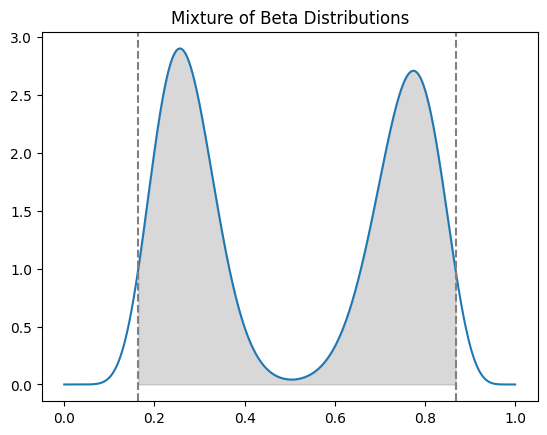

In [33]:
plot_mixture(mixed_pdf, lower_bound, upper_bound)

We can get the HDP region instead by using the `hdi` function from the `arviz` package:

In [34]:
import arviz as az

hdi_bounds = az.hdi(theta_mixed, hdi_prob=0.95, multimodal=True)
print(f"HPD Interval: {hdi_bounds}")

# plot_mixture(mixed_pdf, hdi_bounds[0], hdi_bounds[1])

HPD Interval: [[0.12964154 0.41108837]
 [0.60282402 0.90186127]]


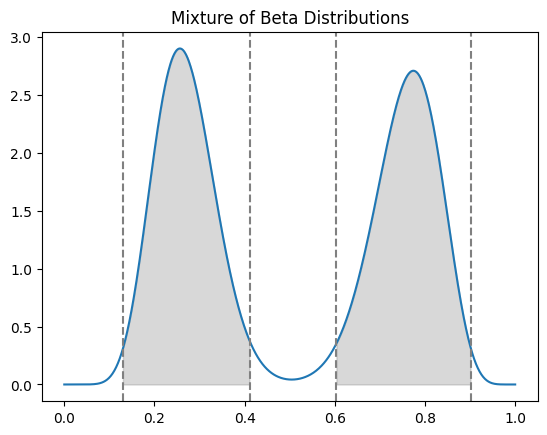

In [36]:
plot_mixture(mixed_pdf, lower_bound=[t[0] for t in hdi_bounds], upper_bound=[t[1] for t in hdi_bounds])

## Posterior Mean as a Convex Combination of Means

The mean of the posterior distribution is often called a ***Bayes Estimator***, denote:
$$\hat \theta_{\text{Bayes}}(Y) \coloneqq E[\lambda|Y]$$

The Gamma distribution has mean $\alpha/\beta$, so the Gamma-distributed posterior from ch 2 $\text{Gamma}(\alpha + n \bar y, \beta + n)$ has mean:
$$E[\lambda | Y = y] = \frac{\alpha + n \bar y}{\beta + n}$$
This may be expressed as a ***Convex Combination*** of the means of the prior distribution $\text{Gamma}(\alpha, \beta)$ and of the observations $Y$:
$$ E[\lambda | Y = y] = \frac{\alpha + n \bar y}{\beta + n} = k\frac{\alpha}{\beta} + (1 - k) \bar y$$
In this case, the mixing proportion is: $$k = \frac{\beta}{\beta + n}$$
Note that due to the $n$ in the denominator, the contribution of the observed data through $\bar y$ will grow larger as $n$ increases.

We can derive this mixing proportion algebraically for many friendly conjugate distributions (e.g. Beta has $k = (\alpha + \beta)/ (\alpha + \beta + n)$)